In [1]:
### Load the previously saved hyperband results by re-defining tuners, but with overwrite=False ###

import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf

def build_model(hp):
    """Model building function."""

    # Define hyperparameters to tune
    num_hidden_layers = hp.Int('num_layers', min_value=2, max_value=5, default=3)
    hidden_layer_size = hp.Int('hidden_layer_size', min_value=16, max_value=128, step=16, default=64)
    activation = hp.Choice('activation', values=['relu', 'tanh', 'selu'], default='relu')
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, default=0.2, step=0.05)
    l2_strength = hp.Float('l2_strength', min_value=1e-5, max_value=1e-2, default=0.001, step=1e-5)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, default=1e-3, step=1e-4)

    # Build the model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=(10,)))
    for _ in range(num_hidden_layers):
        model.add(
            tf.keras.layers.Dense(
                hidden_layer_size,
                activation=activation,
                kernel_regularizer=tf.keras.regularizers.l2(l2_strength)
            )
        )
        # Dropout layer after each Dense layer
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(2,activation='softmax',))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


tuner_smote = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=150,
    factor=3,
    directory='tuning_results',
    project_name='smote_balance_approach',
    overwrite=False # IMPORTANT: Add this parameter!
)

tuner_undersample = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=100,
    factor=3,
    directory='tuning_results',
    project_name='undersample_balance_approach',
    overwrite=False # IMPORTANT: Add this parameter!
)

# Reload existing results
tuner_smote.reload()
tuner_undersample.reload()

Reloading Tuner from tuning_results\smote_balance_approach\tuner0.json
Reloading Tuner from tuning_results\undersample_balance_approach\tuner0.json


In [2]:
### Load data for best HPT models and prepare for plotting ###

def get_model_data(tuner, num_models):
    """
    Function to retrieve model data (model, train loss, val loss, hyperparameters) from a Keras Tuner object.
    
    Arguments:
    - tuner: Keras Tuner object for the specific hyperparameter tuning project.
    - num_models: The number of top models to explore.
    
    Returns:
    - data_dict: Dictionary containing models' data.
    """

    data_dict = {
        'models': [],
        'hps': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'train_loss': [],
        'val_loss': [],
        'train_val_loss_diff': []
    }
    
    best_models = tuner.get_best_models(num_models=num_models)
    best_trials = tuner.oracle.get_best_trials(num_trials=num_models)
    best_hps = tuner.get_best_hyperparameters(num_trials=num_models)
    
    for i in range(num_models):
        trial = best_trials[i]
        hp = best_hps[i]
        train_accuracy = round(trial.metrics.get_history('accuracy')[-1].value[0] * 100, 2)
        val_accuracy = round(trial.metrics.get_history('val_accuracy')[-1].value[0] * 100, 2)
        train_loss = round(trial.metrics.get_history('loss')[-1].value[0], 4)
        val_loss = round(trial.metrics.get_history('val_loss')[-1].value[0], 4)

        
        # Store the relevant data in the dictionary
        data_dict['models'].append(best_models[i])
        data_dict['hps'].append(hp.values)
        data_dict['train_accuracy'].append(train_accuracy)
        data_dict['val_accuracy'].append(val_accuracy)
        data_dict['train_loss'].append(train_loss)
        data_dict['val_loss'].append(val_loss)
        data_dict['train_val_loss_diff'].append(abs(train_loss - val_loss))
    
    return data_dict


# Call the function twice, once for SMOTE data and once for undersample data
num_models = 10
smote_data = get_model_data(tuner_smote, num_models)
undersample_data = get_model_data(tuner_undersample, num_models)

c:\Users\alowe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\alowe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\alowe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\alowe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\sa

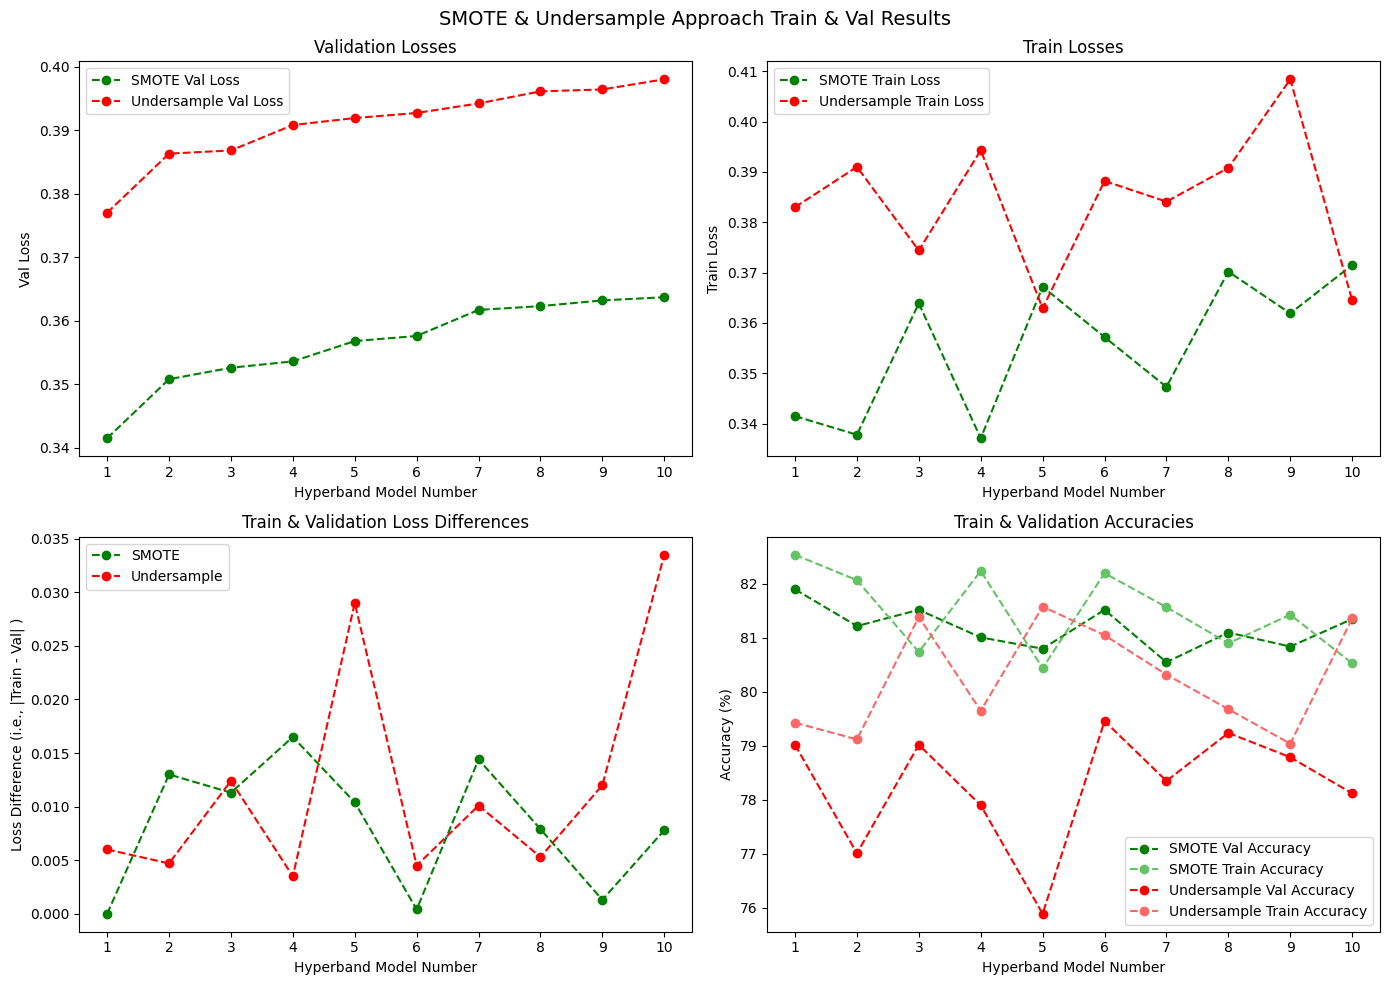

In [6]:
### Plot the data for accuracies and losses for each HPT project ###

def plot_comparisons(smote_data, undersample_data):
    
    # Define subplots layout
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    num_models = len(smote_data['val_loss'])
    x_ticks = list(range(1, num_models + 1))

    # Plot 1: Validation Loss
    axes[0, 0].plot(x_ticks, smote_data['val_loss'], label='SMOTE Val Loss', marker='o', linestyle='--', color='green')
    axes[0, 0].plot(x_ticks, undersample_data['val_loss'], label='Undersample Val Loss', marker='o', linestyle='--', color='red')
    axes[0, 0].set_title('Validation Losses')
    axes[0, 0].set_xlabel('Hyperband Model Number')
    axes[0, 0].set_ylabel('Val Loss')
    axes[0, 0].set_xticks(x_ticks)
    axes[0, 0].legend()

    # Plot 2: Train Loss
    axes[0, 1].plot(x_ticks, smote_data['train_loss'], label='SMOTE Train Loss', marker='o', linestyle='--', color='green')
    axes[0, 1].plot(x_ticks, undersample_data['train_loss'], label='Undersample Train Loss', marker='o', linestyle='--', color='red')
    axes[0, 1].set_title('Train Losses')
    axes[0, 1].set_xlabel('Hyperband Model Number')
    axes[0, 1].set_ylabel('Train Loss')
    axes[0, 1].set_xticks(x_ticks)
    axes[0, 1].legend()

    # Plot 3: Train & Validation Loss Differences
    axes[1, 0].plot(x_ticks, smote_data['train_val_loss_diff'], label='SMOTE', marker='o', linestyle='--', color='green')
    axes[1, 0].plot(x_ticks, undersample_data['train_val_loss_diff'], label='Undersample', marker='o', linestyle='--', color='red')
    axes[1, 0].set_title('Train & Validation Loss Differences')
    axes[1, 0].set_xlabel('Hyperband Model Number')
    axes[1, 0].set_ylabel('Loss Difference (i.e., |Train - Val| )')
    axes[1, 0].set_xticks(x_ticks)
    axes[1, 0].legend()

    # Plot 4: Training & Validation Accuracy
    axes[1, 1].plot(x_ticks, smote_data['val_accuracy'], label='SMOTE Val Accuracy', marker='o', linestyle='--', color='green')
    axes[1, 1].plot(x_ticks, smote_data['train_accuracy'], label='SMOTE Train Accuracy', marker='o', linestyle='--', color='#66C266') # Light green
    axes[1, 1].plot(x_ticks, undersample_data['val_accuracy'], label='Undersample Val Accuracy', marker='o', linestyle='--', color='red')
    axes[1, 1].plot(x_ticks, undersample_data['train_accuracy'], label='Undersample Train Accuracy', marker='o', linestyle='--', color='#FF6666') # Light red
    axes[1, 1].set_title('Train & Validation Accuracies')
    axes[1, 1].set_xlabel('Hyperband Model Number')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].set_xticks(x_ticks)
    axes[1, 1].legend()

    fig.suptitle('SMOTE & Undersample Approach Train & Val Results', fontsize=14)
    plt.tight_layout()
    plt.show()

# Call the function with the SMOTE and Undersample data
plot_comparisons(smote_data, undersample_data)


### Analysis of HPT data - key takeaways ###

SMOTE models: Performs well with a moderate gap between train and validation loss, indicating generalization without severe overfitting.
Undersampled models: Lower train loss but significantly higher val loss suggests overfitting. Running k-fold cross-validation is recommended to better evaluate performance.

Conclusion: Run stratified k-fold CV on undersampled dataset models. This is further supported by the fact that the k-fold CV is typically run on small datasets (<10,000).
Alternatively, one could just choose a SMOTE model (or an ensemble of multiple) as the final model at this point.


In [4]:
### Stratified K-fold Cross Validation on the 10 best Undersampled Dataset Models ###

# Load the data
npz_data = np.load('data/audiobooks_data_split_undersampled.npz')
X_train = tf.convert_to_tensor(npz_data['X_train'], dtype=tf.float64)
X_val = tf.convert_to_tensor(npz_data['X_val'], dtype=tf.float64)
X_test = tf.convert_to_tensor(npz_data['X_test'], dtype=tf.float64)
y_train = tf.convert_to_tensor(npz_data['y_train'], dtype=tf.int8)
y_val = tf.convert_to_tensor(npz_data['y_val'], dtype=tf.int8)
y_test = tf.convert_to_tensor(npz_data['y_test'], dtype=tf.int8)

# Merge training and validation data for k-fold CV
X_train_val = tf.concat([X_train, X_val], axis=0)
y_train_val = tf.concat([y_train, y_val], axis=0)

# Define a function to build models during the CV process
def build_cv_model(hp_dict):
    """Model building function."""

    hidden_layer_size = hp_dict['hidden_layer_size']
    activation = hp_dict['activation']
    num_hidden_layers = hp_dict['num_layers']
    dropout_rate = hp_dict['dropout_rate']
    l2_strength = hp_dict['l2_strength']
    learning_rate = hp_dict['learning_rate']

    # Build the model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=(10,)))
    for _ in range(num_hidden_layers):
        model.add(
            tf.keras.layers.Dense(
                hidden_layer_size,
                activation=activation,
                kernel_regularizer=tf.keras.regularizers.l2(l2_strength)
            )
        )
        # Dropout layer after each Dense layer
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(2,activation='softmax',))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Setup StratifiedKFold Cross-Validation and initialize loss and accuracy lists
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results = {
    'cv_train_loss': [],
    'cv_val_loss': [],
    'cv_train_val_loss_diff': [],
    'cv_train_accuracy': [],
    'cv_val_accuracy': []
}

# Loop over hyperparameter configurations (for each model)
for hp_dict in undersample_data['hps']:
    print(f"Training model with hyperparameters: {hp_dict}")
    
    # Initialize temporary lists for the results of this model's k-fold CV
    temp_train_loss, temp_val_loss = [], []
    temp_train_accuracy, temp_val_accuracy = [], []

    # Run K-Fold cross-validation for this model
    for train_index, val_index in skf.split(X_train_val, y_train_val):
        X_train_fold = tf.gather(X_train_val, train_index)
        X_val_fold = tf.gather(X_train_val, val_index)
        y_train_fold = tf.gather(y_train_val, train_index)
        y_val_fold = tf.gather(y_train_val, val_index)

        # Build and train the model with current hyperparameters
        model = build_cv_model(hp_dict)
        history = model.fit(
            X_train_fold,
            y_train_fold,
            epochs=100,
            batch_size=128,
            validation_data=(X_val_fold, y_val_fold),
            verbose=0
        )
        
        # Collect results for this fold
        temp_train_loss.append(history.history['loss'][-1])
        temp_val_loss.append(history.history['val_loss'][-1])
        temp_train_accuracy.append(history.history['accuracy'][-1])
        temp_val_accuracy.append(history.history['val_accuracy'][-1])

    # After k-folds, compute average results for this model
    cv_results['cv_train_loss'].append(np.round(np.mean(temp_train_loss), 4))
    cv_results['cv_val_loss'].append(np.round(np.mean(temp_val_loss), 4))
    cv_results['cv_train_val_loss_diff'].append(np.round(abs(np.mean(temp_train_loss) - np.mean(temp_val_loss)), 4))
    cv_results['cv_train_accuracy'].append(np.round(np.mean(temp_train_accuracy) * 100, 2))
    cv_results['cv_val_accuracy'].append(np.round(np.mean(temp_val_accuracy) * 100, 2))


Training model with hyperparameters: {'num_layers': 5, 'hidden_layer_size': 16, 'activation': 'tanh', 'dropout_rate': 0.2, 'l2_strength': 9e-05, 'learning_rate': 0.0051, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 4, 'tuner/round': 4, 'tuner/trial_id': '0142'}
Training model with hyperparameters: {'num_layers': 5, 'hidden_layer_size': 16, 'activation': 'tanh', 'dropout_rate': 0.2, 'l2_strength': 9e-05, 'learning_rate': 0.0051, 'tuner/epochs': 34, 'tuner/initial_epoch': 12, 'tuner/bracket': 4, 'tuner/round': 3, 'tuner/trial_id': '0138'}
Training model with hyperparameters: {'num_layers': 2, 'hidden_layer_size': 64, 'activation': 'relu', 'dropout_rate': 0.30000000000000004, 'l2_strength': 0.0004900000000000001, 'learning_rate': 0.01, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0204'}
Training model with hyperparameters: {'num_layers': 4, 'hidden_layer_size': 32, 'activation': 'selu', 'dropout_rate': 0.15000

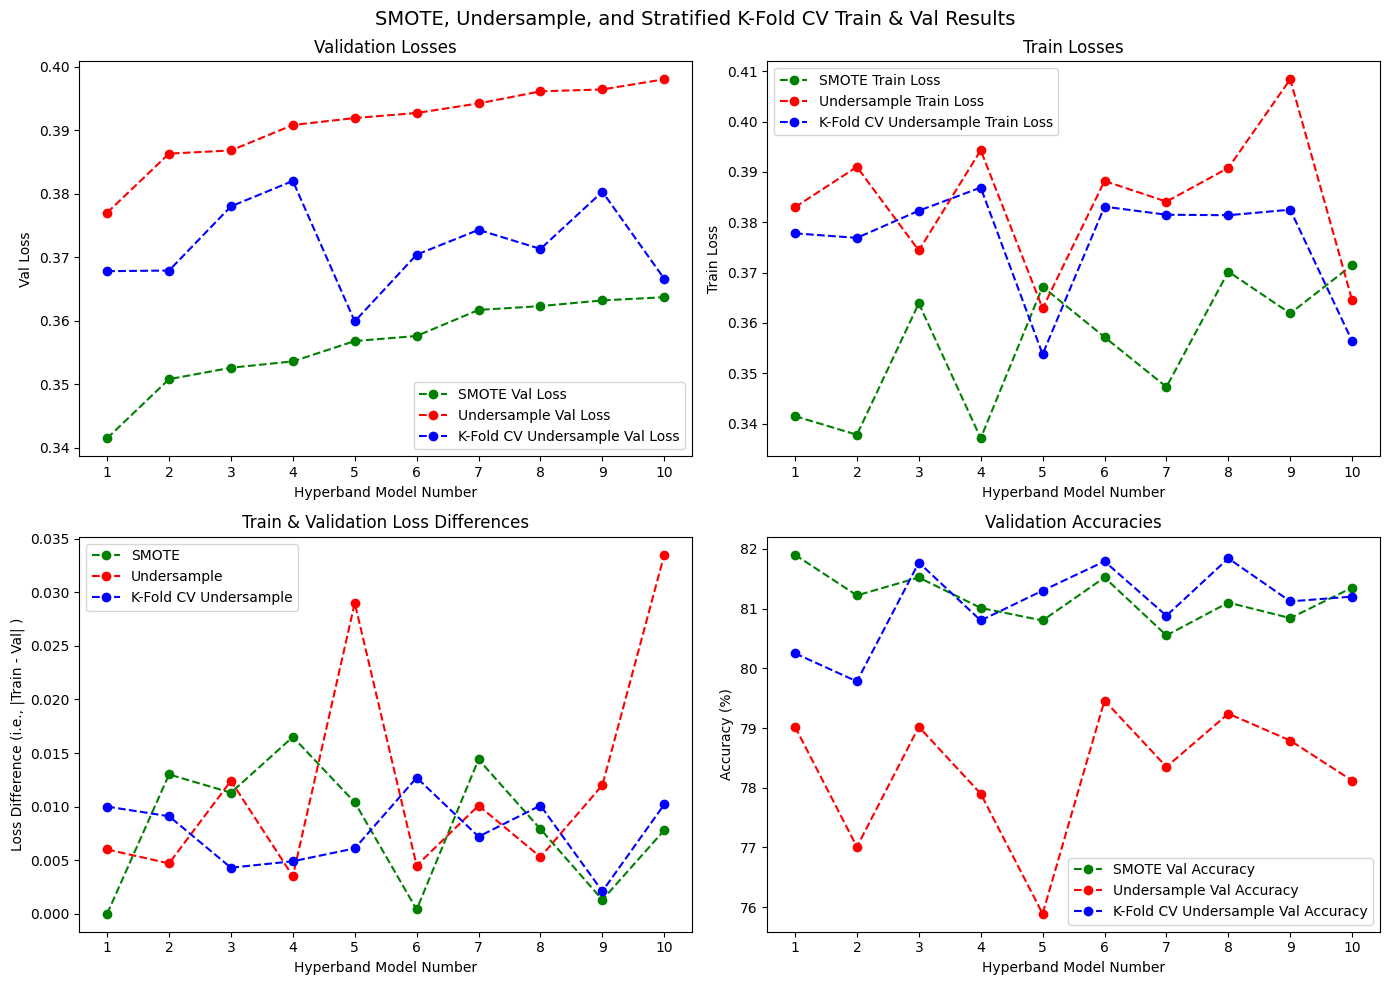

In [9]:
### Plot the new CV data with the HPT data ###

# Add cv_results to undersample data dict
undersample_data.update(cv_results)

def plot_cv_comparisons(smote_data, undersample_data):
    
    # Define subplots layout
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    num_models = len(smote_data['val_loss'])
    x_ticks = list(range(1, num_models + 1))

    # Plot 1: Validation Loss
    axes[0, 0].plot(x_ticks, smote_data['val_loss'], label='SMOTE Val Loss', marker='o', linestyle='--', color='green')
    axes[0, 0].plot(x_ticks, undersample_data['val_loss'], label='Undersample Val Loss', marker='o', linestyle='--', color='red')
    axes[0, 0].plot(x_ticks, undersample_data['cv_val_loss'], label='K-Fold CV Undersample Val Loss', marker='o', linestyle='--', color='blue')
    axes[0, 0].set_title('Validation Losses')
    axes[0, 0].set_xlabel('Hyperband Model Number')
    axes[0, 0].set_ylabel('Val Loss')
    axes[0, 0].set_xticks(x_ticks)
    axes[0, 0].legend()

    # Plot 2: Train Loss
    axes[0, 1].plot(x_ticks, smote_data['train_loss'], label='SMOTE Train Loss', marker='o', linestyle='--', color='green')
    axes[0, 1].plot(x_ticks, undersample_data['train_loss'], label='Undersample Train Loss', marker='o', linestyle='--', color='red')
    axes[0, 1].plot(x_ticks, undersample_data['cv_train_loss'], label='K-Fold CV Undersample Train Loss', marker='o', linestyle='--', color='blue')
    axes[0, 1].set_title('Train Losses')
    axes[0, 1].set_xlabel('Hyperband Model Number')
    axes[0, 1].set_ylabel('Train Loss')
    axes[0, 1].set_xticks(x_ticks)
    axes[0, 1].legend()

    # Plot 3: Train & Validation Loss Differences
    axes[1, 0].plot(x_ticks, smote_data['train_val_loss_diff'], label='SMOTE', marker='o', linestyle='--', color='green')
    axes[1, 0].plot(x_ticks, undersample_data['train_val_loss_diff'], label='Undersample', marker='o', linestyle='--', color='red')
    axes[1, 0].plot(x_ticks, undersample_data['cv_train_val_loss_diff'], label='K-Fold CV Undersample', marker='o', linestyle='--', color='blue')
    axes[1, 0].set_title('Train & Validation Loss Differences')
    axes[1, 0].set_xlabel('Hyperband Model Number')
    axes[1, 0].set_ylabel('Loss Difference (i.e., |Train - Val| )')
    axes[1, 0].set_xticks(x_ticks)
    axes[1, 0].legend()

    # Plot 4: Validation Accuracy (Training removed from this plot - Too busy if it was kept in)
    axes[1, 1].plot(x_ticks, smote_data['val_accuracy'], label='SMOTE Val Accuracy', marker='o', linestyle='--', color='green')
    axes[1, 1].plot(x_ticks, undersample_data['val_accuracy'], label='Undersample Val Accuracy', marker='o', linestyle='--', color='red')
    axes[1, 1].plot(x_ticks, undersample_data['cv_val_accuracy'], label='K-Fold CV Undersample Val Accuracy', marker='o', linestyle='--', color='blue')
    axes[1, 1].set_title('Validation Accuracies')
    axes[1, 1].set_xlabel('Hyperband Model Number')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].set_xticks(x_ticks)
    axes[1, 1].legend()

    fig.suptitle('SMOTE, Undersample, and Stratified K-Fold CV Train & Val Results', fontsize=14)
    plt.tight_layout()
    plt.show()

# Call the function
plot_cv_comparisons(smote_data, undersample_data)
